INF6804<br>
Polytechnique Montréal<br>
TP3: Détection et suivi de multiples objets d'intérêt<br>

Auteurs:<br>
Marc-Olivier Bélanger - 1840713<br>
Pierre-Luc Chartier - 1805679

### Déclarations globales

In [231]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import motmetrics as mm
import numpy as np
import os
import scipy.optimize as sci
import torchvision.models as models
import torchvision.transforms as transforms
import urllib.request as request

In [232]:
COCO_NAMES = ['background']
label_names = request.urlopen('https://raw.githubusercontent.com/gabilodeau/INF6804/master/utils/coco-labels.txt')
for label_name in label_names.readlines():
    COCO_NAMES.append(label_name.strip().decode('UTF-8'))

IOU_THRESHOLD = 0.5
SCORE_THRESHOLD = 0.95

source_path = "/Users/mabelal/Downloads/TP3_data/frames"

model = models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()

In [233]:
# taken from https://answers.opencv.org/question/90455/how-to-perform-intersection-or-union-operations-on-a-rect-in-python/
def intersection_area(a, b):
    x_min = max(a[0], b[0])
    y_min = max(a[1], b[1])
    x_max = min(a[2], b[2])
    y_max = min(a[3], b[3])
    
    width = x_max - x_min
    height = y_max - y_min
    
    if width < 0 or height < 0:
        return 0
    
    return width*height


def union_area(a, b):
    w_a = a[2] - a[0]
    h_a = a[3] - a[1]
    
    w_b = b[2] - b[0]
    h_b = b[3] - b[1]
    
    area_a = w_a * h_a
    area_b = w_b * h_b
    
    return area_a + area_b - intersection_area(a, b)


def intersection_over_union(a, b):
    return intersection_area(a, b) / union_area(a, b)

### Détection des objets (Mask R-CNN)

In [234]:
def detect_objects(img):
    preprocess = transforms.Compose([transforms.ToTensor()])
    tensors = [preprocess(img)]
    
    predictions = model(tensors)
    boxes = []
    
    for p in predictions:
        for j, score in enumerate(p['scores']):
            if score >= SCORE_THRESHOLD:
                #label = p['labels'][j]
                #is_cup_or_person = (COCO_NAMES[label] == "cup") #or (COCO_NAMES[label] == "person")

                #if is_cup_or_person:
                boxes.append(p['boxes'][j].detach().numpy())
    return boxes

### Description des objets (Histogramme de couleurs)

In [235]:
def calc_color_hist(img, bbox):
    roi = (bbox[0], bbox[1], bbox[2], bbox[3])
    mask = np.zeros((img.shape[0],img.shape[1]), np.uint8)
    cv2.rectangle(mask,(roi[0],roi[1]),(roi[2],roi[3]),255,-1,8,0);
    return cv2.calcHist([img],[0],mask,[64],[0,256])


def compare_color_hist(hist1, hist2):
    return cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)

### Association des données (Mean-Shift et algorithme hongrois)

In [236]:
def calc_cost_matrix(tracked_objects, current_img, current_bboxes):
    cost_matrix = np.zeros((len(tracked_objects), len(current_bboxes)))
    for i in range(0,len(tracked_objects)):
        for j in range(0,len(current_bboxes)):
            hist_current = calc_color_hist(current_img, current_bboxes[j])
            cost_matrix[i,j] = compare_color_hist(tracked_objects[i].histogram, hist_current)
    return cost_matrix


def mean_shift(tracked_obj, current_img):           
    retro = cv2.calcBackProject([current_img], [0], tracked_obj.histogram, [0,64], 1)

    end_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )
    
    to_box = tracked_obj.box()    
    iterations, box = cv2.meanShift(retro, (to_box[0], to_box[1], to_box[2]-to_box[0], to_box[3]-to_box[1]), end_crit)
    x_min, y_min, width, height = box
    
    return x_min, y_min, x_min+width, y_min+height

        
def associate_data(tracked_objects, current_img, current_bboxes):    
    cost_matrix = calc_cost_matrix(tracked_objects, current_img, current_bboxes)
    row_ind, col_ind = sci.linear_sum_assignment(cost_matrix)
    
    for i in range(0, len(row_ind)):
        # check if association from hungarian algorithm makes sense based on IOU
        iou_score = intersection_over_union(tracked_objects[row_ind[i]].box(), current_bboxes[col_ind[i]])
        if iou_score > IOU_THRESHOLD:
            # model detected object, update it with its predicted bbox and update its description
            tracked_objects[row_ind[i]].was_detected = True
            x_min, y_min, x_max, y_max = current_bboxes[col_ind[i]]
            tracked_objects[row_ind[i]].update(x_min, y_min, x_max, y_max)
            tracked_objects[row_ind[i]].histogram = calc_color_hist(current_img, tracked_objects[row_ind[i]].box())
    
    # apply mean-shift to tracked objects that were not detected by the model
    # update to predicted box if IOU > threshold
    for ob in tracked_objects.values():
        if not ob.was_detected:
            x_min, y_min, x_max, y_max = mean_shift(ob, current_img)
            
            iou_score = intersection_over_union(ob.box(), (x_min, y_min, x_max, y_max))
            if iou_score > IOU_THRESHOLD:
                ob.update(x_min, y_min, x_max, y_max)
        else:
            # reset for next frame
            ob.was_detected = False          
            
    return row_ind, col_ind


def associate_data_mot(tracked_objects, current_img, current_bboxes):
    cost_matrix = calc_cost_matrix(tracked_objects, current_img, current_bboxes)
    row_ind, col_ind = sci.linear_sum_assignment(cost_matrix)
    
    return row_ind, cost_matrix

### Algorithme principal

In [237]:
class TrackedObject:
    def __init__(self, object_id, x_min, y_min, x_max, y_max):
        self.object_id = object_id
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.was_detected = False
        self.histogram = None
    
    
    def update(self, x_min, y_min, x_max, y_max):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
            
    
    def box(self):
        return self.x_min, self.y_min, self.x_max, self.y_max
    
    
    def __str__(self):
        ws = " "
        return ws.join([str(self.object_id+1), str(round(self.x_min)),
                        str(round(self.x_max)), str(round(self.y_min)), str(round(self.y_max))])

In [238]:
def algo(path_to_frames, tracked_objects, result_file):
    # some magic to get the frames in the right order
    frames = [name for name in os.listdir(path_to_frames) if os.path.isfile(os.path.join(path_to_frames, name))]
    frames = sorted(frames)
    frames = sorted(frames, key = lambda s : len(s))
        
    # initial frame
    prev_img = cv2.imread(os.path.join(path_to_frames, frames[0]), cv2.IMREAD_GRAYSCALE)
    for ob in tracked_objects.values():
        ob.histogram = calc_color_hist(prev_img, ob.box())
    
    f = open(result_file, "w+")
    for i in range(0, len(tracked_objects)):
        f.write("1 " + str(tracked_objects[i]) + "\n")
    
    # main loop
    for i in range(1, len(frames)):
        img = cv2.imread(os.path.join(path_to_frames, frames[i]), cv2.IMREAD_GRAYSCALE)
        boxes = detect_objects(img)
        associate_data(tracked_objects, img, boxes)
        
        for j in range(0, len(tracked_objects)):
            f.write(str(i+1) + " " + str(tracked_objects[j]) + "\n")
        
        if (i % 5) == 0:
            print("Progress: " + frames[i])
    
    f.close()

In [239]:
def algo_mot(path_to_gt, path_to_frames):
    f = open(path_to_gt, "r")
    lines = f.readlines()
    f.close()

    frames = [name for name in os.listdir(path_to_frames) if os.path.isfile(os.path.join(path_to_frames, name))]
    frames = sorted(frames)

    acc = mm.MOTAccumulator(auto_id=True)
    
    # build tracked_objects using first ground truth frame of every object
    tracked_objects = { }
    current_obj_id = 0
    for gt in lines:
        frame, obj_id , x, y, w, h = gt.split(",")[:6]
        if int(obj_id) != current_obj_id:
            img = cv2.imread(os.path.join(path_to_frames, frames[int(frame)-1]), cv2.IMREAD_GRAYSCALE)
            current_obj_id = int(obj_id)
            tracked_objects[current_obj_id-1] = TrackedObject(current_obj_id-1, int(x), int(y), int(x)+int(w), int(y)+int(h))
            tracked_objects[current_obj_id-1].histogram = calc_color_hist(img, tracked_objects[current_obj_id-1].box())
    
    # main loop
    for i in range(0, len(frames)):
        img = cv2.imread(os.path.join(path_to_frames, frames[i]), cv2.IMREAD_GRAYSCALE)
        boxes = detect_objects(img)
        row_ind, cost_matrix = associate_data_mot(tracked_objects, img, boxes)
        
        gt_objects = []
        for gt in lines:
            frame, obj_id = gt.split(",")[:2]
            if int(frame) == (i + 1):
                gt_objects.append(int(obj_id)-1)
        gt_objects = np.array(gt_objects)
        
        distances = []
        for j in gt_objects:
            distances.append(cost_matrix[j])
        distances = np.array(distances)
        
        acc.update(gt_objects, row_ind, distances)
        
        # show progress
        if (i+1)%5 == 0:
            print("Progress: ", frames[i])
        
    return acc

### Test de l'association des données

1 588 799 363 577
2 1062 1441 555 981
[1]
[0]


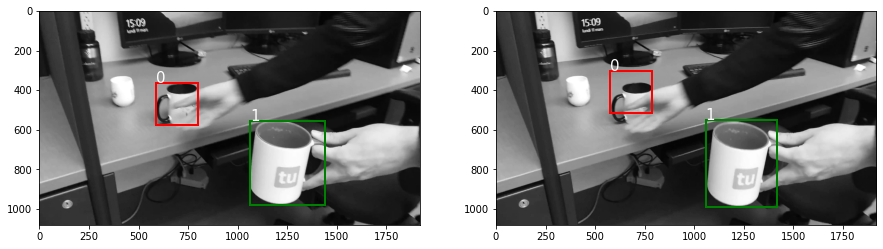

1 574 785 302 516
2 1058 1420 549 991


In [240]:
### Test association des données ###

img = cv2.imread(os.path.join(source_path, "frame124.jpg"), cv2.IMREAD_GRAYSCALE)
cup_1 = TrackedObject(0, 588, 363, 799, 577)
cup_2 = TrackedObject(1, 1062, 555, 1441, 981)

# modelisation des objets a partir de la premiere image
first_img = cv2.imread(os.path.join(source_path, "frame1.jpg"), cv2.IMREAD_GRAYSCALE)
cup_1.histogram = calc_color_hist(first_img, cup_1.box())
cup_2.histogram = calc_color_hist(first_img, cup_2.box())

tracked_objects = {
    cup_1.object_id : cup_1,
    cup_2.object_id : cup_2
}

img2 = cv2.imread(os.path.join(source_path, "frame125.jpg"), cv2.IMREAD_GRAYSCALE)
b2 = detect_objects(img2)

fig, axarr = plt.subplots(1, 2, figsize=(15,15))
bboxcolor = 'rgbcmy'

axarr[0].imshow(img, cmap = plt.cm.gray)
for i in range(0, len(tracked_objects)):
    b = tracked_objects[i].box()
    rect = patches.Rectangle((b[0],b[1]),b[2]-b[0],b[3]-b[1],linewidth=2, edgecolor = bboxcolor[i], facecolor='none')
    axarr[0].add_patch(rect)
    axarr[0].text(b[0], b[1], i, color='white', fontsize=15)

for to in tracked_objects.values():
    print(to)

row_ind, col_ind = associate_data(tracked_objects, img2, b2)
print(row_ind)
print(col_ind)

axarr[1].imshow(img2, cmap = plt.cm.gray)
#for i, b in enumerate(b2):
for i in range(0, len(tracked_objects)):
    b = tracked_objects[i].box()
    rect = patches.Rectangle((b[0],b[1]),b[2]-b[0],b[3]-b[1],linewidth=2, edgecolor = bboxcolor[i], facecolor='none')
    axarr[1].add_patch(rect)
    rect = patches.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], linewidth=2, edgecolor=bboxcolor[i], facecolor='none')
    axarr[1].add_patch(rect)
    axarr[1].text(b[0], b[1], i, color='white', fontsize=15)
    
plt.show()

for to in tracked_objects.values():
    print(to)
    
############

### MOT17-11: Forward moving camera in a busy shopping mall

In [241]:
path_to_gt = "/Users/mabelal/Downloads/TP3_data/MOT17-11-FRCNN/gt/gt.txt"
src_path = "/Users/mabelal/Downloads/TP3_data/MOT17-11-FRCNN/img1"

acc = algo_mot(path_to_gt, src_path)

Progress:  000005.jpg
Progress:  000010.jpg
Progress:  000015.jpg
Progress:  000020.jpg
Progress:  000025.jpg
Progress:  000030.jpg
Progress:  000035.jpg
Progress:  000040.jpg
Progress:  000045.jpg
Progress:  000050.jpg
Progress:  000055.jpg
Progress:  000060.jpg
Progress:  000065.jpg
Progress:  000070.jpg
Progress:  000075.jpg
Progress:  000080.jpg
Progress:  000085.jpg
Progress:  000090.jpg
Progress:  000095.jpg
Progress:  000100.jpg
Progress:  000105.jpg
Progress:  000110.jpg
Progress:  000115.jpg
Progress:  000120.jpg
Progress:  000125.jpg
Progress:  000130.jpg
Progress:  000135.jpg
Progress:  000140.jpg
Progress:  000145.jpg
Progress:  000150.jpg
Progress:  000155.jpg
Progress:  000160.jpg
Progress:  000165.jpg
Progress:  000170.jpg
Progress:  000175.jpg
Progress:  000180.jpg
Progress:  000185.jpg
Progress:  000190.jpg
Progress:  000195.jpg
Progress:  000200.jpg
Progress:  000205.jpg
Progress:  000210.jpg
Progress:  000215.jpg
Progress:  000220.jpg
Progress:  000225.jpg
Progress: 

#### MOTA:

In [242]:
mh = mm.metrics.create()
summary = mh.compute(acc, metrics=['num_frames', 'mota', 'motp'], name='acc')
print(summary)

     num_frames      mota      motp
acc         900  0.543185  0.356561


### MOT17-05: Street scene from a moving platform

In [243]:
path_to_gt = "/Users/mabelal/Downloads/TP3_data/MOT17-05-FRCNN/gt/gt.txt"
src_path = "/Users/mabelal/Downloads/TP3_data/MOT17-05-FRCNN/img1"

acc = algo_mot(path_to_gt, src_path)

Progress:  000005.jpg
Progress:  000010.jpg
Progress:  000015.jpg
Progress:  000020.jpg
Progress:  000025.jpg
Progress:  000030.jpg
Progress:  000035.jpg
Progress:  000040.jpg
Progress:  000045.jpg
Progress:  000050.jpg
Progress:  000055.jpg
Progress:  000060.jpg
Progress:  000065.jpg
Progress:  000070.jpg
Progress:  000075.jpg
Progress:  000080.jpg
Progress:  000085.jpg
Progress:  000090.jpg
Progress:  000095.jpg
Progress:  000100.jpg
Progress:  000105.jpg
Progress:  000110.jpg
Progress:  000115.jpg
Progress:  000120.jpg
Progress:  000125.jpg
Progress:  000130.jpg
Progress:  000135.jpg
Progress:  000140.jpg
Progress:  000145.jpg
Progress:  000150.jpg
Progress:  000155.jpg
Progress:  000160.jpg
Progress:  000165.jpg
Progress:  000170.jpg
Progress:  000175.jpg
Progress:  000180.jpg
Progress:  000185.jpg
Progress:  000190.jpg
Progress:  000195.jpg
Progress:  000200.jpg
Progress:  000205.jpg
Progress:  000210.jpg
Progress:  000215.jpg
Progress:  000220.jpg
Progress:  000225.jpg
Progress: 

#### MOTA:

In [244]:
mh = mm.metrics.create()
summary = mh.compute(acc, metrics=['num_frames', 'mota', 'motp'], name='acc')
print(summary)

     num_frames      mota      motp
acc         837  0.469986  0.300729


### MOT17-13 : Filmed from a bus on a busy intersection

In [245]:
path_to_gt = "/Users/mabelal/Downloads/TP3_data/MOT17-13-FRCNN/gt/gt.txt"
src_path = "/Users/mabelal/Downloads/TP3_data/MOT17-13-FRCNN/img1"

acc = algo_mot(path_to_gt, src_path)

Progress:  000005.jpg
Progress:  000010.jpg
Progress:  000015.jpg
Progress:  000020.jpg
Progress:  000025.jpg
Progress:  000030.jpg
Progress:  000035.jpg
Progress:  000040.jpg
Progress:  000045.jpg
Progress:  000050.jpg
Progress:  000055.jpg
Progress:  000060.jpg
Progress:  000065.jpg
Progress:  000070.jpg
Progress:  000075.jpg
Progress:  000080.jpg
Progress:  000085.jpg
Progress:  000090.jpg
Progress:  000095.jpg
Progress:  000100.jpg
Progress:  000105.jpg
Progress:  000110.jpg
Progress:  000115.jpg
Progress:  000120.jpg
Progress:  000125.jpg
Progress:  000130.jpg
Progress:  000135.jpg
Progress:  000140.jpg
Progress:  000145.jpg
Progress:  000150.jpg
Progress:  000155.jpg
Progress:  000160.jpg
Progress:  000165.jpg
Progress:  000170.jpg
Progress:  000175.jpg
Progress:  000180.jpg
Progress:  000185.jpg
Progress:  000190.jpg
Progress:  000195.jpg
Progress:  000200.jpg
Progress:  000205.jpg
Progress:  000210.jpg
Progress:  000215.jpg
Progress:  000220.jpg
Progress:  000225.jpg
Progress: 

#### MOTA:

In [246]:
mh = mm.metrics.create()
summary = mh.compute(acc, metrics=['num_frames', 'mota', 'motp'], name='acc')
print(summary)

     num_frames      mota      motp
acc         750  0.312246  0.419061


### Résultats sur les trames fournies

In [40]:
# init.txt
cup_1 = TrackedObject(0, 830, 474, 1112, 755)
cup_2 = TrackedObject(1, 1194, 433, 1479, 700)

tracked_objects = {
    cup_1.object_id : cup_1,
    cup_2.object_id : cup_2
}

algo("/Users/mabelal/Downloads/TP3_data/frames", tracked_objects, "result_cups.txt")

Progress: frame6.jpg
Progress: frame11.jpg
Progress: frame16.jpg
Progress: frame21.jpg
Progress: frame26.jpg
Progress: frame31.jpg
Progress: frame36.jpg
Progress: frame41.jpg
Progress: frame46.jpg
Progress: frame51.jpg
Progress: frame56.jpg
Progress: frame61.jpg
Progress: frame66.jpg
Progress: frame71.jpg
Progress: frame76.jpg
Progress: frame81.jpg
Progress: frame86.jpg
Progress: frame91.jpg
Progress: frame96.jpg
Progress: frame101.jpg
Progress: frame106.jpg
Progress: frame111.jpg
Progress: frame116.jpg
Progress: frame121.jpg
Progress: frame126.jpg
Progress: frame131.jpg
Progress: frame136.jpg
Progress: frame141.jpg
Progress: frame146.jpg
Progress: frame151.jpg
Progress: frame156.jpg
Progress: frame161.jpg
Progress: frame166.jpg
Progress: frame171.jpg
Progress: frame176.jpg
Progress: frame181.jpg
Progress: frame186.jpg
Progress: frame191.jpg
Progress: frame196.jpg
Progress: frame201.jpg
Progress: frame206.jpg
Progress: frame211.jpg
Progress: frame216.jpg
Progress: frame221.jpg
Progress

### Validation des résultats

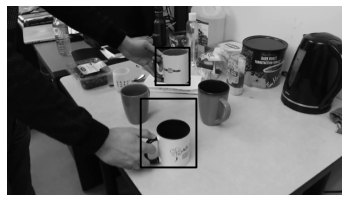

frame501.jpg
501 1 851 1046 238 452

501 2 766 1085 529 922



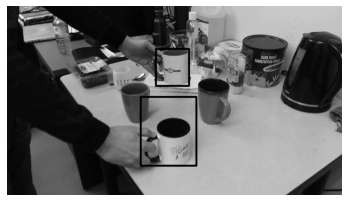

frame502.jpg
502 1 853 1043 245 456

502 2 766 1085 519 912



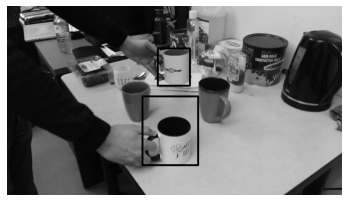

frame503.jpg
503 1 864 1048 242 455

503 2 776 1095 516 909



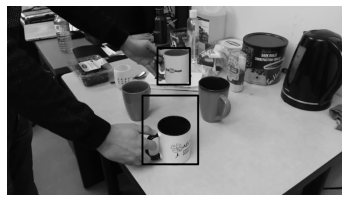

frame504.jpg
504 1 862 1048 240 449

504 2 776 1095 511 904



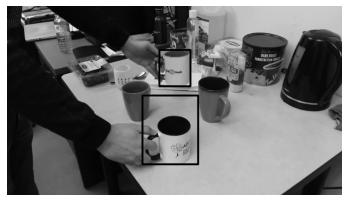

frame505.jpg
505 1 873 1051 251 458

505 2 776 1095 511 904



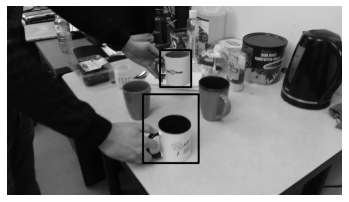

frame506.jpg
506 1 877 1055 252 463

506 2 779 1098 504 897



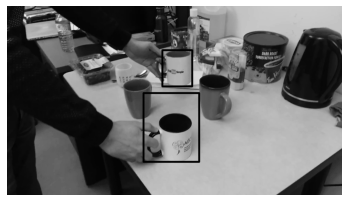

frame507.jpg
507 1 890 1061 252 459

507 2 782 1101 497 890



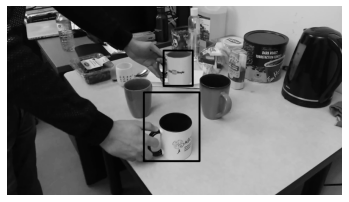

frame508.jpg
508 1 897 1064 254 456

508 2 784 1103 493 886



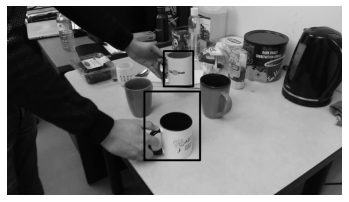

frame509.jpg
509 1 898 1067 257 459

509 2 787 1106 488 881



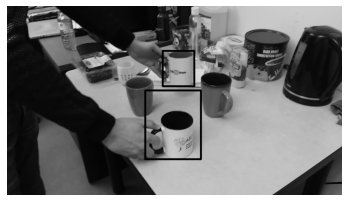

frame510.jpg
510 1 892 1073 256 458

510 2 792 1111 482 875



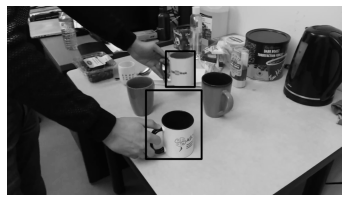

frame511.jpg
511 1 910 1076 258 462

511 2 796 1115 481 874



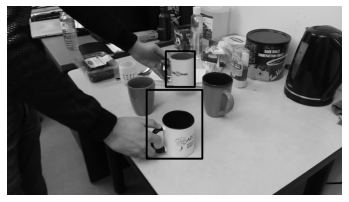

frame512.jpg
512 1 910 1076 258 462

512 2 800 1119 479 872



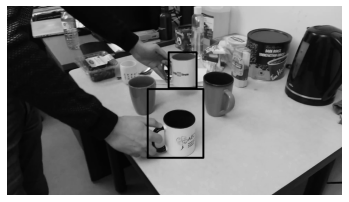

frame513.jpg
513 1 926 1086 264 469

513 2 806 1125 474 867



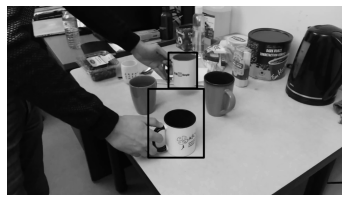

frame514.jpg
514 1 925 1089 266 470

514 2 809 1128 473 866



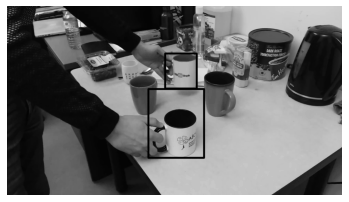

frame515.jpg
515 1 906 1087 271 471

515 2 810 1129 474 867



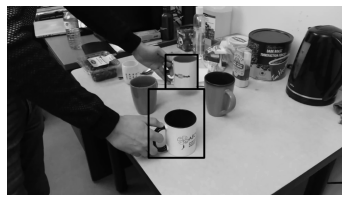

frame516.jpg
516 1 908 1092 278 474

516 2 811 1130 474 867



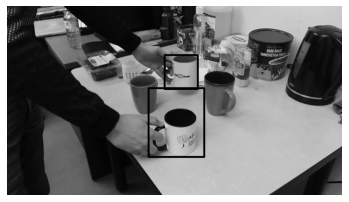

frame517.jpg
517 1 903 1093 280 474

517 2 811 1130 469 862



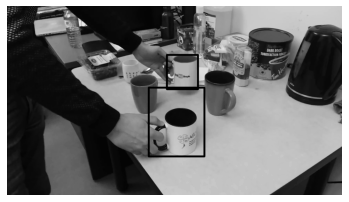

frame518.jpg
518 1 916 1094 279 475

518 2 812 1131 466 859



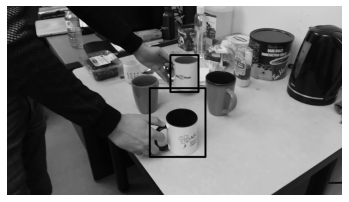

frame519.jpg
519 1 936 1097 280 491

519 2 818 1137 469 862



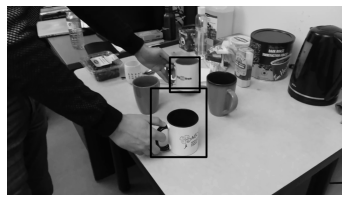

frame520.jpg
520 1 933 1104 293 492

520 2 824 1143 470 863



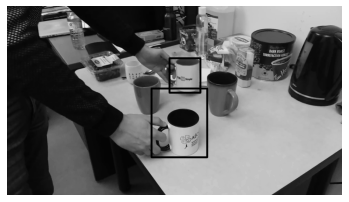

frame521.jpg
521 1 931 1108 298 495

521 2 828 1147 471 864



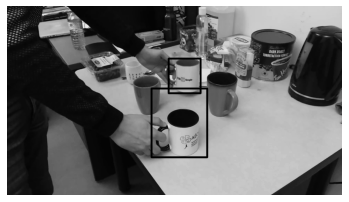

frame522.jpg
522 1 926 1109 300 498

522 2 828 1147 471 864



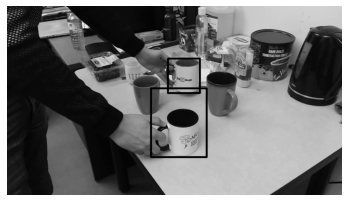

frame523.jpg
523 1 922 1105 300 497

523 2 825 1144 470 863



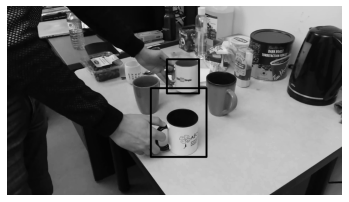

frame524.jpg
524 1 916 1100 304 499

524 2 824 1143 469 862



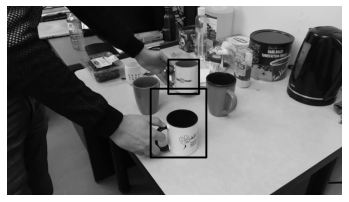

frame525.jpg
525 1 924 1100 306 502

525 2 823 1142 472 865



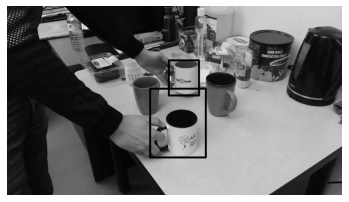

frame526.jpg
526 1 927 1100 310 511

526 2 820 1139 472 865



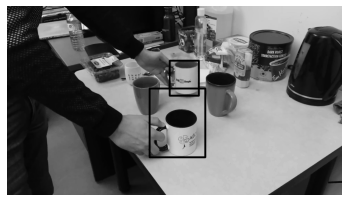

frame527.jpg
527 1 932 1099 312 512

527 2 817 1136 471 864



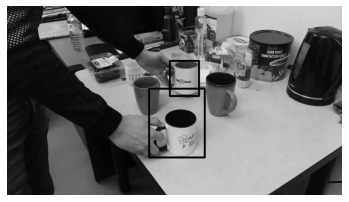

frame528.jpg
528 1 933 1100 313 514

528 2 814 1133 472 865



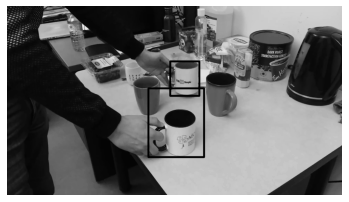

frame529.jpg
529 1 935 1102 316 513

529 2 810 1129 470 863



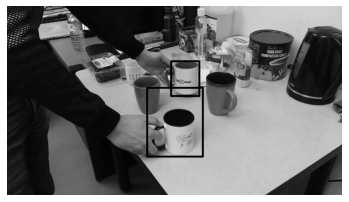

frame530.jpg
530 1 940 1102 315 514

530 2 803 1122 467 860



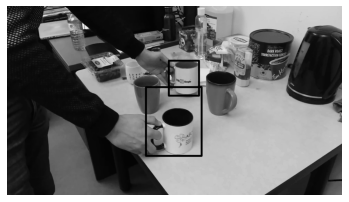

frame531.jpg
531 1 927 1100 312 512

531 2 796 1115 463 856



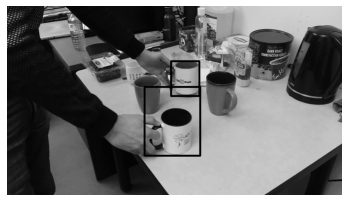

frame532.jpg
532 1 940 1102 315 514

532 2 788 1107 462 855



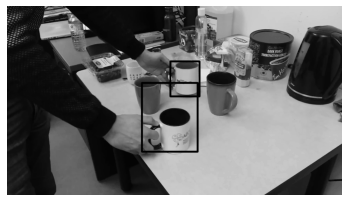

frame533.jpg
533 1 936 1103 316 516

533 2 773 1092 439 832



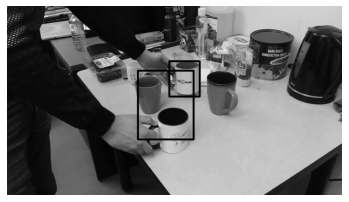

frame534.jpg
534 1 930 1104 315 517

534 2 750 1069 369 762



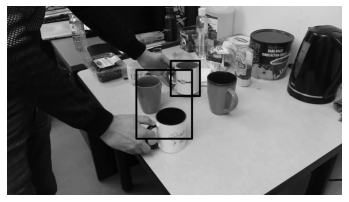

frame535.jpg
535 1 938 1105 313 514

535 2 741 1060 365 758



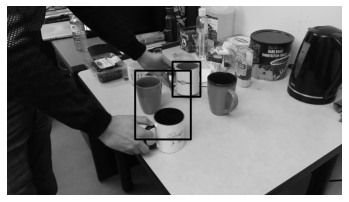

frame536.jpg
536 1 948 1108 318 518

536 2 734 1053 369 762



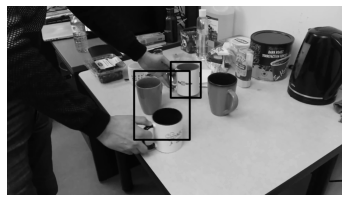

frame537.jpg
537 1 938 1110 319 524

537 2 728 1047 371 764



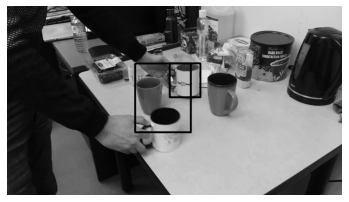

frame538.jpg
538 1 932 1108 327 521

538 2 734 1053 328 721



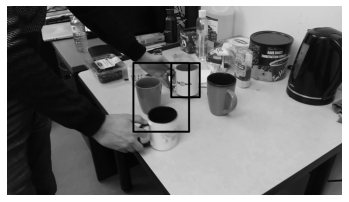

frame539.jpg
539 1 941 1104 326 521

539 2 724 1043 325 718



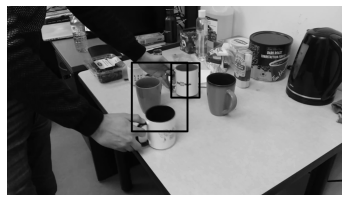

frame540.jpg
540 1 941 1103 326 523

540 2 715 1034 323 716



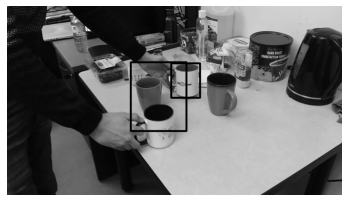

frame541.jpg
541 1 941 1106 327 524

541 2 709 1028 321 714



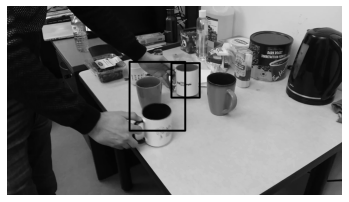

frame542.jpg
542 1 942 1104 326 523

542 2 702 1021 319 712



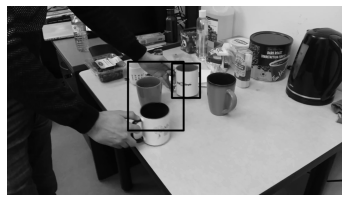

frame543.jpg
543 1 945 1106 328 525

543 2 693 1012 318 711



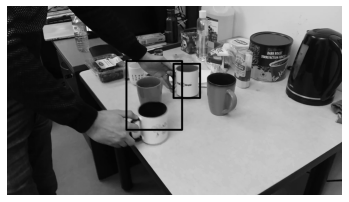

frame544.jpg
544 1 954 1106 330 525

544 2 684 1003 314 707



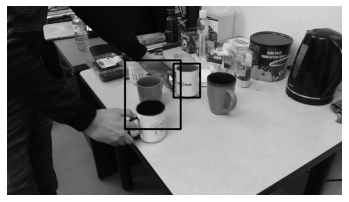

frame545.jpg
545 1 954 1106 329 523

545 2 676 995 310 703



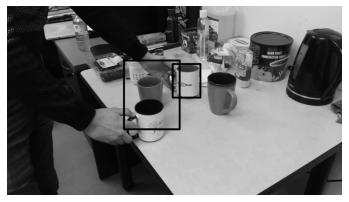

frame546.jpg
546 1 949 1108 331 523

546 2 670 989 311 704



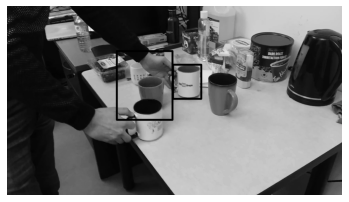

frame547.jpg
547 1 951 1113 335 530

547 2 629 948 257 650



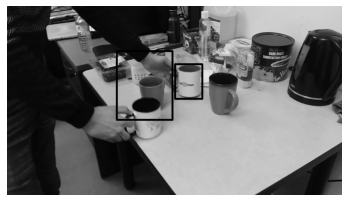

frame548.jpg
548 1 963 1119 332 530

548 2 629 948 257 650



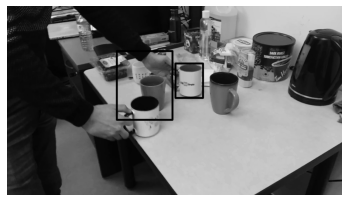

frame549.jpg
549 1 965 1123 328 525

549 2 629 948 257 650



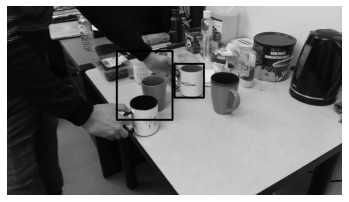

frame550.jpg
550 1 960 1128 330 523

550 2 629 948 257 650



In [73]:
### Validation des résultats

f = open("/Users/mabelal/result_cups_5.txt", "r")
lines = f.readlines()
f.close()

frames = [name for name in os.listdir(source_path) if os.path.isfile(os.path.join(source_path, name))]
frames = sorted(frames)
frames = sorted(frames, key = lambda s : len(s))

i = 501
for j in range (0, 50):
    img = cv2.imread(os.path.join(source_path, frames[i-1+j]), cv2.IMREAD_GRAYSCALE)
    
    x_min, x_max, y_min, y_max = lines[(2*(i-1+j))].split(" ")[-4:]
    img = cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0,0,0), 10)
    
    x_min, x_max, y_min, y_max = lines[(2*(i-1+j))+1].split(" ")[-4:]
    img = cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0,0,0), 10)
    
    plt.imshow(img, cmap=plt.cm.gray)
    plt.axis("off")
    plt.show()
    
    print(frames[i-1+j])
    print(lines[(2*(i-1+j))])
    print(lines[(2*(i-1+j))+1])
